# Filter responce curve
2022-05-25 H. Akitaya

## SDSS filter response curve
- http://hikari.astron.s.u-tokyo.ac.jp/work/SDSS/filters.html
- 9808UB1 (u1): http://hikari.astron.s.u-tokyo.ac.jp/work/SDSS/filters/57mm/9808UB1

In [1]:
from urllib.request import urlopen
import numpy as np

In [2]:
%matplotlib inline

In [3]:
wl = []
trans = []

In [4]:
with urlopen("http://hikari.astron.s.u-tokyo.ac.jp/work/SDSS/filters/57mm/9808UB1") as f:
    for line in f:
        decoded_line = line.decode("utf-8")
        wl.append(float(decoded_line.split()[0]))
        trans.append(float(decoded_line.split()[1]))

In [5]:
wl = np.array(wl) / 10.0  # Angstrom to nm.
trans = np.array(trans)

In [6]:
np.set_printoptions(threshold=21)

In [7]:
wl

array([ 300.,  301.,  302., ..., 1098., 1099., 1100.])

In [8]:
import matplotlib.pyplot as plt

In [9]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

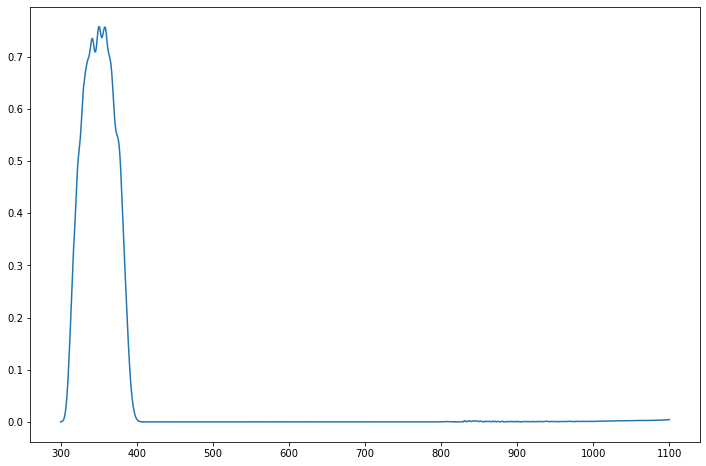

In [10]:
fig, (ax) = plt.subplots(1, 1, figsize=(12,8))
ax.plot(wl, trans)

In [11]:
import scipy

In [12]:
from scipy import integrate

In [13]:
# help(integrate)

In [14]:
# help(integrate.quad)

In [15]:
from scipy.interpolate import interp1d

In [16]:
filter_curve = interp1d(wl, trans)

In [17]:
type(filter_curve)

scipy.interpolate._interpolate.interp1d

Normalize integration.

In [18]:
filter_integ = integrate.quad(filter_curve, 300, 400)

<ipython-input-18-26540617d2ba>:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  filter_integ = integrate.quad(filter_curve, 300, 400)


In [19]:
print(filter_integ)

(45.23371804883179, 0.004747921568913682)


In [20]:
def filter_f(wl):
    try:
        filter_tr = float(filter_curve(wl))/filter_integ[0]
    except ValueError:
        filter_tr = None
    return filter_tr

In [21]:
filter_tr = filter_f(320.1)

In [22]:
type(filter_tr)

float

In [23]:
float(filter_tr)

0.009310753530040135

normalized filter response curve (transmittance/nm)

In [24]:
x = np.linspace(300, 400, 1001)

In [25]:
filter_curve_nrm = interp1d(wl, trans/filter_integ[0])

In [26]:
y = filter_curve_nrm(x)

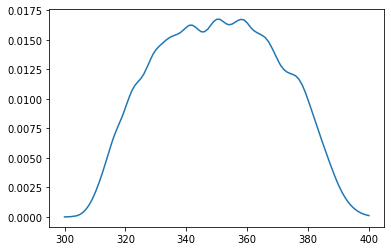

In [27]:
plt.plot(x, y)

Check for integration of the normalized function.

In [28]:
integrate.quad(filter_curve_nrm, 300, 400)

<ipython-input-28-3dda3b8c891c>:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(filter_curve_nrm, 300, 400)


(0.9999999999999998, 0.00010496421195815842)

OK.

In [29]:
def filter_f_nrm(wl):
    try:
        filter_tr = float(filter_curve_nrm(wl))
    except ValueError:
        filter_tr = None
    return filter_tr

## Atmospheric transmittion at u'-band

### Lowtran7  Atmospheric model

- Users Guide to LOWTRAN 7
https://apps.dtic.mil/sti/pdfs/ADA206773.pdf

```
MODEL = 
0 If meteorological data are specified (horizontal path only)
1 Tropical Atmosphere
2 Midlatitude Summer
3 Midlatitude Winter
4 Subarctic Summer
5 Subarctic Whiter
6 1976 US Standard
```

In [30]:
import lowtran

In [31]:
help(lowtran)

Help on package lowtran:

NAME
    lowtran

DESCRIPTION
    Michael Hirsch, Ph.D.
    Python wrapper of the venerable LOWTRAN7 atmospheric absorption and solar transmission
    model circa 1992.
    
    Note: specified Lowtran7 model limitations include
    wlcminvstep >= 20 cm^-1
    0 <= wlcminv <= 50000
    
    historical note:
    developed on CDC CYBER, currently runs on 32-bit single float--this can cause loss of numerical
    precision, future would like to ensure full LOWTRAN7 code can run at 64-bit double float.
    
    user manual:
    www.dtic.mil/dtic/tr/fulltext/u2/a206773.pdf

PACKAGE CONTENTS
    base
    plots
    scenarios

FILE
    /home/akitaya/research/atmosphere/lowtran/src/lowtran/__init__.py




In [32]:
def get_transmittance(model, h1, angle=0.0, wlshort=200.0, wllong=900.0, wlstep=10.0):
    """ Get lowtran transmittance as xarray.Dataset.
    """
    ltrn_params = {
        "model": model,  # Subarctic winter.
        "h1": h1,  # Observer altitude. [km]
        "angle": angle,  # Zentih angle. [deg]
        "wlshort": wlshort,  # Shortest wavelength. [nm]
        "wllong": wllong,  # Longest wavelength. [nm]
        "wlstep": wlstep,  # Wavelength step. [nm]
    }
    tr = lowtran.transmittance(ltrn_params)
    wls =tr.coords['wavelength_nm'].values
    trs = np.ndarray.flatten(tr['transmission'][0, :].values)
    return wls, trs

In [33]:
atm_wls, atm_trs = get_transmittance(3, 0.0)

In [34]:
atm_trs_curve = interp1d(atm_wls, atm_trs)

In [35]:
import matplotlib.pyplot as plt

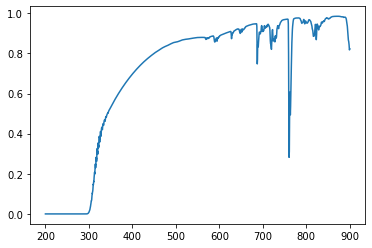

In [36]:
plt.plot(atm_wls, atm_trs)

In [37]:
def atm_trans_f(wl):
    try:
        trans = float(atm_trs_curve(wl))
    except ValueError:
        trans = None
    return trans

In [38]:
tmp = atm_trans_f(310.0)

In [39]:
tmp

0.14717718621690778

Interpolated function for the atmospheric transmittance.

In [40]:
def atm_f(wl):
    try:
        atm_tr = float(atm_trs_curve(wl))
    except ValueError:
        atm_tr = None
    return atm_tr

In [41]:
atm_f(400.0)

0.6966928243514801

## Transmittance of the atmosphere weighted by the u'-band efficiency curve.

In [42]:
def atm_times_filter(wl):
    return atm_f(wl) * filter_f_nrm(wl)

In [43]:
integrate.quad(atm_times_filter, 300.0, 400.0)

<ipython-input-43-e0d6b5e29cf3>:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(atm_times_filter, 300.0, 400.0)


(0.512695791185331, 0.00016046374452083345)

effective wavelength

$$
\lambda_\mathrm{eff} = \frac{\int{T_\mathrm{filter}(\lambda)\ T_\mathrm{atm}(\lambda)\lambda\ {\mathrm d}\lambda}}{\int{T_\mathrm{filter}(\lambda)\ T_\mathrm{atm}(\lambda)\ {\mathrm d}\lambda}}
$$

In [44]:
def atm_times_filter_times_wl(wl):
    return atm_f(wl)*filter_f_nrm(wl)*wl

In [45]:
wl_eff = integrate.quad(atm_times_filter_times_wl, 300, 400)[0]/integrate.quad(atm_times_filter, 300.0, 400.0)[0]

<ipython-input-45-002cf57053c3>:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  wl_eff = integrate.quad(atm_times_filter_times_wl, 300, 400)[0]/integrate.quad(atm_times_filter, 300.0, 400.0)[0]


In [46]:
wl_eff

354.3697665647832

Calculate filter weighted transmittance at arbitray altitude.

In [47]:
def get_filter_weighted_transmittance(model, h1):
    wl1 = 300.0
    wl2 = 400.0
    _atm_wls, _atm_trs = get_transmittance(model, h1)
    _atm_trs_curve = interp1d(_atm_wls, _atm_trs)
    def _atm_times_filter(wl):
        return float(_atm_trs_curve(wl)) * filter_f_nrm(wl)
    result_trans = integrate.quad(_atm_times_filter, wl1, wl2)
    return result_trans[0]

In [48]:
get_filter_weighted_transmittance(3, 1.0)

<ipython-input-47-8eb3e42928c5>:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result_trans = integrate.quad(_atm_times_filter, wl1, wl2)


0.5518786500222681

In [49]:
heights = np.linspace(0, 5.5, 12)  # km
models = {
    2: 'Midlatitude Summer',
    3: 'Midlatitude Winter',
    4: 'Subarctic Summer',
    5: 'Subarctic Winter',
    6: '1976 US Standard',
}         

In [50]:
fwtrans = {}
import sys
for model in models:
    sys.stdout.write('{} '.format(model))
    fwtrans[model] = []
    for h1 in heights:
        fwtrans[model].append(get_filter_weighted_transmittance(model, h1))

2 

<ipython-input-47-8eb3e42928c5>:8: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result_trans = integrate.quad(_atm_times_filter, wl1, wl2)


3 4 5 6 

In [51]:
print(fwtrans)

{2: [0.5147190861164521, 0.5330539938776591, 0.5511325629634183, 0.5689229645440457, 0.5863961597970078, 0.6035372102590659, 0.6203336636875919, 0.6367680957032892, 0.6528252553249563, 0.6684857536181723, 0.68373240571809, 0.6985476844894821], 3: [0.512695791185331, 0.5324614670771334, 0.5518786500222681, 0.5709077989701261, 0.5895136159988449, 0.6076657119501317, 0.6253379672482375, 0.6425462700210487, 0.6593088823368888, 0.6756067068408832, 0.6914234158672582, 0.7067430960007669], 4: [0.5159620939475151, 0.5347220877421784, 0.5532368767390944, 0.5714667616852602, 0.5893745012281848, 0.6069289944078564, 0.6241022426358279, 0.6408660918067409, 0.65719537363392, 0.6730743051132501, 0.6884897188946258, 0.7034541697549542], 5: [0.5146910780414616, 0.5354577164075713, 0.5556275640698926, 0.5752602474349029, 0.5944195821389243, 0.6130733622654401, 0.6311943682533225, 0.6487901415005718, 0.6658711847946668, 0.6824450242077629, 0.6985215228588043, 0.7140795586962645], 6: [0.5152765568884614, 

In [52]:
tibet_u_band = {
    'height': 5.130,  # km
    'trans':  10**(-2/5*0.366),
}  # Liu+2022

In [53]:
tibet_u_band['trans']

0.7138385536016629

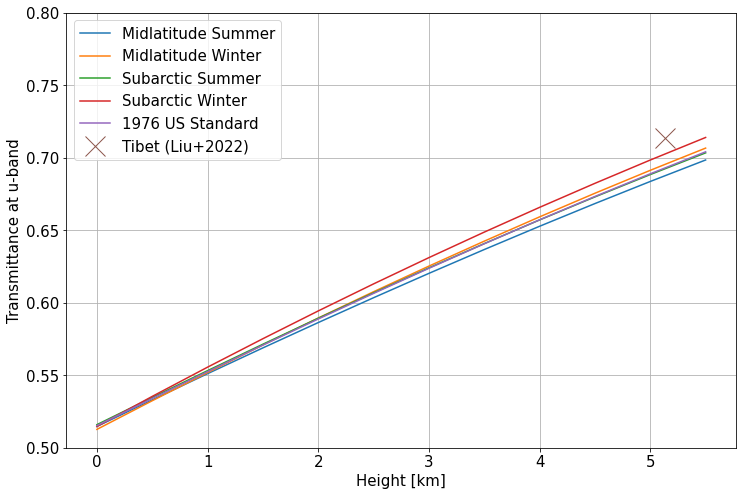

In [54]:
plt.rcParams['font.size'] = 15
fig1, (ax1) = plt.subplots(1,1, figsize=(12,8))
for model in models:
    ax1.plot(heights, fwtrans[model], label='{}'.format(models[model]))
ax1.plot(tibet_u_band['height'], tibet_u_band['trans'], 'x', markersize=20,
         label='Tibet (Liu+2022)')
ax1.set_xlabel('Height [km]')
ax1.set_ylabel('Transmittance at u''-band')
ax1.set_ylim([0.5,0.8])
ax1.grid()
ax1.legend(loc='upper left')

Mauna Kea (Gemini-N) transmittance

http://www.gemini.edu/observing/telescopes-and-sites/sites#Extinction

In [55]:
from astropy.table import Table

In [56]:
sources = """
wavelength extinction
310 1.37
320 0.82
340 0.51
360 0.37
380 0.30
400 0.25
450 0.17
500 0.13
550 0.12
600 0.11
650 0.11
700 0.10
800 0.07
900 0.05
"""

In [57]:
data = Table.read(sources, format='ascii')

In [58]:
data

<Table length=14>
wavelength extinction
  int64     float64  
---------- ----------
       310       1.37
       320       0.82
       340       0.51
       360       0.37
       380        0.3
       400       0.25
       450       0.17
       500       0.13
       550       0.12
       600       0.11
       650       0.11
       700        0.1
       800       0.07
       900       0.05

In [59]:
data.add_column(10**(-2/5*data['extinction']), name='tr')

In [60]:
data

<Table length=14>
wavelength extinction         tr        
  int64     float64        float64      
---------- ---------- ------------------
       310       1.37 0.2831391995799379
       320       0.82 0.4698941086052154
       340       0.51 0.6251726927756858
       360       0.37 0.7112135136533291
       380        0.3 0.7585775750291838
       400       0.25 0.7943282347242815
       450       0.17 0.8550667128846833
       500       0.13 0.8871560120379609
       550       0.12 0.8953647655495938
       600       0.11 0.9036494737223014
       650       0.11 0.9036494737223014
       700        0.1 0.9120108393559098
       800       0.07 0.9375620069258802
       900       0.05 0.9549925860214359

In [61]:
atm_trs_curve_gn = interp1d(data['wavelength'], data['tr'])

In [62]:
def atm_f_gn(wl):
    try:
        atm_tr = float(atm_trs_curve_gn(wl))
    except ValueError:
        atm_tr = None
    return atm_tr

In [63]:
atm_f_gn(350)

0.6681931032145074

In [64]:
filter_f_nrm(350)

0.016735303500428268

In [65]:
def atm_times_filter_gn(wl):
    return atm_f_gn(wl) * filter_f_nrm(wl)

In [66]:
integrate.quad(atm_times_filter_gn, 310, 400)

<ipython-input-66-1ccada6b9d16>:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integrate.quad(atm_times_filter_gn, 310, 400)


(0.6433909794282453, 2.089516713565942e-05)

In [67]:
gemini_n_u_band = {
    'height': 4.213,  # km
    'trans':  integrate.quad(atm_times_filter_gn, 310, 400)[0],
}  # Gemini "The Sites": http://www.gemini.edu/observing/telescopes-and-sites/sites#Extinction

<ipython-input-67-c46028f329d7>:3: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  'trans':  integrate.quad(atm_times_filter_gn, 310, 400)[0],


Hanle (Indian Astronomical Obsservatory)

4500 m
https://prints.iiap.res.in/bitstream/handle/2248/2521/paper-86.pdf?sequence=1&isAllowed=y

U: 0.353 +/- 0.037 mag/airmass

https://www.iiap.res.in/?q=iao_site

<pre>
Mean Extinction Values (2003-2008)
U 0.36 +/- 0.07
B 0.21 +/- 0.04
V 0.12 +/- 0.04
R 0.09 +/- 0.04
I 0.05 +/- 0.03
</pre>

In [68]:
hanle_u_band = {
    'height': 4.500,  # km
    'trans':  10**(-2/5*0.353), # err 0.037 mag
}  # Parihar+2003 or https://www.iiap.res.in/?q=iao_site

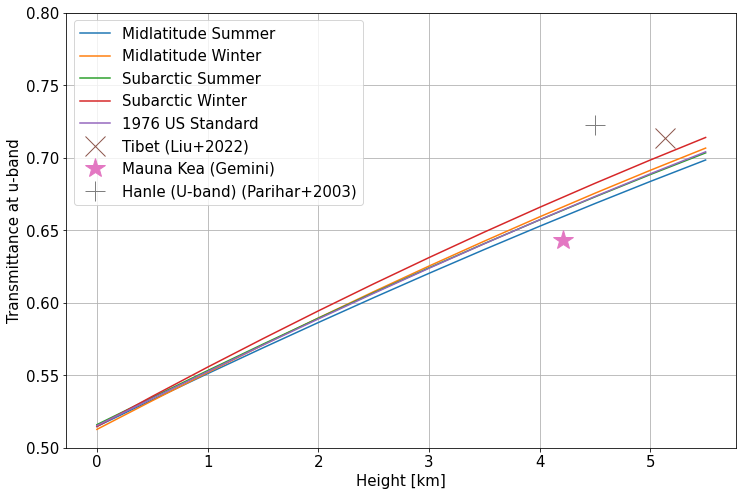

In [70]:
plt.rcParams['font.size'] = 15
fig1, (ax1) = plt.subplots(1,1, figsize=(12,8))
for model in models:
    ax1.plot(heights, fwtrans[model], label='{}'.format(models[model]))
ax1.plot(tibet_u_band['height'], tibet_u_band['trans'], 'x', markersize=20,
         label='Tibet (Liu+2022)')
ax1.plot(gemini_n_u_band['height'], gemini_n_u_band['trans'], '*', markersize=20,
         label='Mauna Kea (Gemini)')
ax1.plot(hanle_u_band['height'], hanle_u_band['trans'], '+', markersize=20,
         label='Hanle (U-band) (Parihar+2003)')
ax1.set_xlabel('Height [km]')
ax1.set_ylabel('Transmittance at u''-band')
ax1.set_ylim([0.5,0.8])
ax1.grid()
ax1.legend(loc='upper left')